# **One-step Diffusion with Distribution Matching Distillation (CVPR 2024)**
##### Tianwei Yin, Michaël Gharbi, Richard Zhang, Eli Shechtman, Fredo Durand, William T. Freeman, Taesung Park
[![arXiv](https://img.shields.io/badge/arXiv-2311.18828-b31b1b.svg)](https://arxiv.org/abs/2311.18828)
---

#### Group Info
- **Group Name:** Group 03
- **Members:**
    - Devrim Çavuşoğlu devrim.cavusoglu@metu.edu.tr
    - Ahmet Burak Yıldırım e270208@metu.edu.tr

## **Introduction**

This paper introduces a method called Distribution Matching Distillation (DMD), which transforms a diffusion model into a one-step image generator with minimal impact on image quality. The authors enforce the one-step image generator to match the diffusion model at the distribution level (distillation). This objective is achieved by minimizing an approximate KL divergence, whose gradient can be expressed as the difference between two score functions, which are the target (teacher) distribution and the synthetic (student) distribution produced by the one-step generator. The performance of this method is reported on ImageNet 64x64, COCO-30k, and CIFAR-10 datasets. Due to computational power restrictions, we tested our implementation on the CIFAR-10 dataset. In the following sections, we provide our implementation details.

## **Training**

For the distillation part, we require a paired dataset of images and latents (and optionally class labels for class-conditioning). Here, we focus on class conditional training of the model, $G_\theta$. The overall pipeline has 3 main components:

Images taken from the official [official project page](https://tianweiy.github.io/dmd/) (slides).

### **Feed signals from a critic**

<center><img src="assets/method_p1.png" alt="imagep1.png" width="800"/></center>

Here the objective is to train the model given noise to be fed by signals from a critic, $\mu_{real}$, (frozen) to make the image more realistic. Here, the generator produces a sample, and after a stochastic diffusion process (random timestep), the generator is optimized from the signal from critic's denoised output to get close to more "real". 

### **Feed signals from two critics**

<center><img src="assets/method_p2.png" alt="imagep2.png" width="800"/></center>

Feeding signals only from a frozen critic, $\mu_{real}$ (teacher) is hard to optimize, and it suffers from mode collapse. The paper introduced another critic $\mu_{fake}$ that is continually trained with a diffusion loss. First, a sample is obtained from the generator, and forward diffusion is applied on the output. After the forward diffusion process, the noisy sample is given to $\mu_{real}$ and $\mu_{fake}$ and denoised versions of the noisy sample are obtained. The difference between the outputs is used to feed the generator, $G_\theta$.


### **Regression Loss**

<center><img src="assets/method_p3.png" alt="image3.png" width="800"/></center>

The final component of the training pipeline is the regression loss. The paper also proposed to use a regression loss between output of $G_\theta$ given the latent from latent-image pairs to the image to better guide the $G_\theta$ to match the distribution of the base model, and the authors still observed mode collapse on feeding signals from two critics (step 2). Besides, the regression loss also helps the model to be signaled also for the class guidance although the objective is a classifier-free guidance.


## **Training Pipeline**

Covering the main components of the training, we first need a teacher model. [EDM](https://arxiv.org/abs/2206.00364) is used as the base model, $\mu_{base}$ in the paper for CIFAR and ImageNet datasets. Here, we will use CIFAR-10 dataset and the EDM class-conditioned model as a teacher. Also, the paper utilized the same base model architecture and weights for all three models, $G_\theta$, $\mu_{real}$ and $\mu_{fake}$. However, we aim to train a one-step model unlike diffusion models that generates samples in several steps, and hence with time conditioning. The authors proposed to fix the timestep for the one-step generator model, $G_\theta$ as $G_\theta(z) = \mu_{base}(z, T-1)$, where in practice $T=1000$ in the experiments.

We specifically use [edm-cifar10-32x32-cond-vp.pkl](https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-cifar10-32x32-cond-vp.pkl) as the base model which was used in the paper for conditional training on CIFAR-10.

After selecting the teacher/base model, we now require a synthetic dataset (latent-image pairs) from the base model. In the experiments we created a latent-image pairs dataset of size 100 K with class labels. The dataset can be reached from [devrim/dmd_cifar10_edm_distillation_dataset](https://huggingface.co/datasets/Devrim/dmd_cifar10_edm_distillation_dataset/tree/main). Particularly we will use the toy dataset that is a subset from the 100 K generated synthetic dataset of 100 samples of the same class (0/airplane) throughout the notebook for convenience.

## **Dataset Samples**

Here the image displaying 10 random images (left) from the real CIFAR-10 dataset, and (right) from the synthetic dataset formed by sampling from the conditional pretrained EDM (base) model on CIFAR-10.

<center><img src="assets/dataset_samples.png"></center>

## **Challenges & Assumptions**

Note that the following items are written only considering the implementation for CIFAR-10.

- Hyperparameters are explicitly stated in the paper, but there's no information for which model they are used. In practice there are two models being optimized ($G_\theta$ and $\mu_{fake}$), we assumed the mentioned hyper-parameters for both model when there is no additional information (e.g. optimizer, lr).
- There are three models in the training phase ($G_\theta$, $\mu_{fake}$ and $\mu_{real}$) and two of them are being optimized. Despite the model sizes are same, having two models being optimized effectively limits the choice of the batch size, and the overall training is memory intensive.
- In the paper, the batch size is stated as 56 across 7 GPUs that corresponds to the batch size of $56 * 7 = 392$ **assuming no gradient accumulation is performed** (i.e. gradient accumulation steps is $1$). Having said this, we performed our training experiments on a single GPU with 24 GiB memory (RTX 4090), and set the batch size accordingly as $48$.
- With the choice of the batch size, we "appropriately" (this is a vague term) scaled the learning rate in our experiments, opted for square root scaling, and set the learning rate as `1.75e-5` scaled from `5e-5`.  

In [ ]:
# # For Google Colab
# ! git clone https://github.com/devrimcavusoglu/dmd.git
# ! mkdir temp
# ! mv dmd/* temp
# ! rm -rf dmd
# ! mv temp/* .
# ! rm -rf temp

# # Install dependencies
# ! pip install -q h5py imageio pillow piq psutil torch requests "scipy>=1.7.1" tqdm torchvision "imageio-ffmpeg>=0.4.3" matplotlib pyspng neptune

In [1]:
"""Sets up the toy test set for FID evaluation (on toy sets). Toy sets are airplane only (`c=0`) and have the size of 100 instances."""

from pathlib import Path

import PIL.Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms


class CIFAR10Toy(Dataset):
    def __init__(self, data_path: str):
        self.data_path = Path(data_path)
        self.transform = transforms.ToTensor()

    def __len__(self):
        return 100

    def __getitem__(self, index):
        img = self.transform(PIL.Image.open(self.data_path / f"im_{index}.png"))
        c = torch.tensor(0)
        return img, c


def create_toy_testset(data_path: str):
    data_path = Path(data_path)
    if data_path.exists():
        return
    data_path.mkdir()
    test_dataset = CIFAR10(
        root=DATA_DIR, train=False, download=True,
    )
    n = 0
    for (img, c) in test_dataset:
        if c != 0:
            continue
        img.save(data_path / f"im_{n}.png")
        n += 1
        if n == 100:
            break

/home/devrim/miniconda3/envs/dmd/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/devrim/miniconda3/envs/dmd/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/devrim/miniconda3/envs/dmd/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104warnERKNS_7WarningE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# # Download the dataset
# # Run `bash scripts/download_data.sh`, optionally you can only download toy dataset.
# ! bash scripts/download_data.sh

In [5]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torchvision.datasets import CIFAR10

from dmd import DATA_DIR, OUTPUTS_DIR
from dmd.modeling_utils import get_fixed_generator_sigma, sample_from_generator, load_edm
from dmd.utils.common import image_grid
from dmd.utils.logging import CheckpointHandler
from dmd.dataset.cifar_pairs import CIFARPairs
from dmd.loss import GeneratorLoss, DenoisingLoss

/home/devrim/miniconda3/envs/dmd/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/devrim/miniconda3/envs/dmd/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104warnERKNS_7WarningE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [6]:
# Constants & Hyper-parameters

BASE_MODEL = "https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-cifar10-32x32-cond-vp.pkl"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Change this accordingly
# For convenience, we use toy dataset here, but feel free to change it to the training 
# dataset (requires according changes to test_data_path).
N_DATASET = 100  # Toy dataset size
DATA_PATH = DATA_DIR / "cifar_toy.hdf5" 
TEST_DATA_PATH = DATA_DIR / "cifar-10-toy-airplane"  # this will be created at dataset generation
OUTPUT_DIR = OUTPUTS_DIR / "toy_test"  # Output directory for saving the model and artifacts.
EPOCHS = 40
BATCH_SIZE = 4
NUM_WORKERS = 10
LR = 5e-5
WEIGHT_DECAY = 0.01
BETAS = (0.9, 0.999)
DMD_LOSS_TIMESTEP = 1000  # value `T`, for discretizing timesteps (e.g. binsize)
DMD_LAMBDA_REG = 0.25  # weight of the regression loss in the combined loss
MAX_NORM = 10.0  # gradient clipping
IM_SAVE_STEPS = int(0.51 * N_DATASET/BATCH_SIZE)  # At what percent of the epoch images should be saved
PRINT_STEPS = int(0.34 * N_DATASET/BATCH_SIZE)  # At what percent of the epoch loss metrics should be printed

In [5]:
# Dataset setup

training_dataset = CIFARPairs(DATA_PATH)
train_loader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

create_toy_testset(TEST_DATA_PATH)  # create toy dataset to match our toy dataset (airplane only and size=100)
test_dataset = CIFAR10Toy(TEST_DATA_PATH)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=NUM_WORKERS)

In [6]:
# Training Setup

# Set up the teacher and student models all models are instatiated from the same base model
mu_real = load_edm(model_path=BASE_MODEL, device=DEVICE)
mu_fake = load_edm(model_path=BASE_MODEL, device=DEVICE)
generator = load_edm(model_path=BASE_MODEL, device=DEVICE)

# Create losses, Generator Loss is the combined loss of DMD and the regression loss (LPIPS)
generator_loss = GeneratorLoss(timesteps=DMD_LOSS_TIMESTEP, lambda_reg=DMD_LAMBDA_REG)
diffusion_loss = DenoisingLoss()

# Create optimizers
generator_optimizer = AdamW(params=generator.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, betas=BETAS)
diffuser_optimizer = AdamW(params=mu_fake.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, betas=BETAS)

# Create ckp handler
checkpoint_handler = CheckpointHandler(
        checkpoint_dir=OUTPUT_DIR, lower_is_better=True
    )  # hardcoded lower_is_better for experimentation

/home/devrim/anaconda3/envs/dmd/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/devrim/anaconda3/envs/dmd/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/devrim/anaconda3/envs/dmd/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### **Training Loop**

For convenience we will use the helper functions from the sourcecode, and for more detail please check the codebase. Here, we will only slightly give an overview of the crucial parts of the training loop discarding the auxiliary stuff like distributed setup, logging, model saving, lr scheduling, etc. Also, we will use the function and classes with the same name as implemented in the codebase. 

**Note:** EDM Models (Karras et al., 2022) are implemented and designed in a way that they take $\sigma_t$ in the forward method not timestep, that is the sigma at the $t^{th}$ position (discretized). Also, EDM Models (Karras et al., 2022) noise scheduling is different from other diffusion models (e.g. DDPM), see `dmd.modeling_utils.get_sigmas_karras`.\
**Note-2:** `generator`, $G_\theta$, is currently a diffusion model (i.e. depends on $t$), but we need one-step generator, and hence a time independent model. To do this, the paper fixes a $\sigma_{t'}$ and use this timestep (sigma) for the `generator`, $G_\theta$, in both training and evaluation, we will call this constant `g_sigma`. In short and abuse of notation $G_\theta(z) = G_\theta(z, T-1)$. This choice (i.e. having a large $t$ such as $T-1$) is intuitively logical as in diffusion models, it's expected that at the furthest stages of forward diffusion, the input is assumed to be converged in distribution to $\mathcal{N}(0,1)$.

The pseudo-codeish training loop is as follows (see `dmd.training.training_loop.train_one_epoch` for more detail):


**Algorithm**

**Input**: pretrained base model `mu_real`, paired dataset `D = {z_ref, y_ref, class_id}` \
**Output**: Trained one-step generator `generator`

```
generator = copy_weights(mu_real)
mu_fake = copy_weights(mu_real)

g_sigma = get_sigmas_karras(t=1000, sigma_min=0.002, sigma_max=80, rho=7.0, device=device)[1000-1]  # Get (T-1)^th sigma. `T=1000` in practice.

# Set generator and mu_fake to train mode, mu_real is frozen
generator.requires_grad_(True).train()
mu_fake.requires_grad_(True).train()
mu_real.requires_grad_(False).eval()

for epoch in range(epochs):
    for (z_ref, y_ref, class_ids) in train_loader:  # all tensors in the preset `device` (e.g. GPU)
        # Generate images from generator
        z = torch.randn_like(y_ref)  # generate random noise from N(0,1) as the same shape of `y_ref` (B,C,H,w)
    
        # Scale z and z_ref with sigma(T-1), see `Note-2`.
        z = z * g_sigma
        z_ref = z_ref * g_sigma  # `z_ref` is the paired latent for `y_ref`
        class_labels = encode_labels(class_ids)  # one-hot encoding
        
        # Update generator (Combined Loss: DMD Loss + Regression Loss)
        x = generator(z, g_sigma, class_labels)
        x_ref = generator(z_ref, g_sigma, class_labels)
    
        # DMD Loss: (mu_real, mu_fake, x, class_labels) and LPIPS: (x_ref, y_ref)
        loss_g = generator_loss(mu_real, mu_fake, x, x_ref, y_ref, class_labels)
        update_parameters(generator, loss_g, generator_optimizer, max_norm)  # update `generator` with gradient clipping at `max_norm`
    
        # Update mu_fake (Denoising loss)
        t = torch.randint(1, 1000, [x.shape[0]])  # `t=0` leads to inf in our implementation, and hence we start from 1
        loss_d = diffusion_loss(mu_fake, x, t, class_labels)
        update_parameters(mu_fake, loss_d, diffusion_optimizer, max_norm)  # update `mu_fake` with gradient clipping at `max_norm`
```


In [7]:
from dmd.train import train

In [8]:
# start training
train(
    generator=generator,
    mu_real=mu_real,
    mu_fake=mu_fake,
    data_loader_train=train_loader,
    data_loader_test=test_loader,
    device=DEVICE,
    loss_g=generator_loss,
    loss_d=diffusion_loss,
    optimizer_g=generator_optimizer,
    optimizer_d=diffuser_optimizer,
    epochs=EPOCHS,
    neptune_run=None,
    cudnn_benchmark=True,
    amp_autocast=None,
    max_norm=MAX_NORM,
    print_freq=PRINT_STEPS,
    im_save_freq=IM_SAVE_STEPS,
    checkpoint_handler=checkpoint_handler,
)

Start training for 40 epochs


/home/devrim/anaconda3/envs/dmd/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/devrim/anaconda3/envs/dmd/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/devrim/anaconda3/envs/dmd/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backend

Epoch: [0]  [ 0/25]  eta: 0:01:51  loss_g: 0.1315 (0.1315)  loss_d: 0.2036 (0.2036)  time: 4.4642  data: 0.4532  max mem: 4191
Epoch: [0]  [ 8/25]  eta: 0:00:16  loss_g: 0.1494 (0.1534)  loss_d: 0.2036 (0.2012)  time: 0.9605  data: 0.0525  max mem: 4191
Epoch: [0]  [16/25]  eta: 0:00:06  loss_g: 0.1612 (0.1582)  loss_d: 0.1925 (0.1892)  time: 0.7556  data: 0.0278  max mem: 4191
Epoch: [0]  [24/25]  eta: 0:00:00  loss_g: 0.1680 (0.1642)  loss_d: 0.1757 (0.1856)  time: 0.5260  data: 0.0010  max mem: 4191
Epoch: [0] Total time: 0:00:17 (0.6863 s / it)
Averaged stats: loss_g: 0.1680 (0.1642)  loss_d: 0.1757 (0.1856)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 16.68it/s]


Test FID: 300.77914130004285
Epoch: [1]  [ 0/25]  eta: 0:00:26  loss_g: 0.1973 (0.1973)  loss_d: 0.4145 (0.4145)  time: 1.0678  data: 0.4039  max mem: 4191
Epoch: [1]  [ 8/25]  eta: 0:00:09  loss_g: 0.1986 (0.1919)  loss_d: 0.1430 (0.2109)  time: 0.5830  data: 0.0467  max mem: 4191
Epoch: [1]  [16/25]  eta: 0:00:04  loss_g: 0.2034 (0.2033)  loss_d: 0.0886 (0.1549)  time: 0.5550  data: 0.0248  max mem: 4191
Epoch: [1]  [24/25]  eta: 0:00:00  loss_g: 0.2075 (0.2016)  loss_d: 0.0940 (0.1683)  time: 0.5223  data: 0.0009  max mem: 4191
Epoch: [1] Total time: 0:00:13 (0.5504 s / it)
Averaged stats: loss_g: 0.2075 (0.2016)  loss_d: 0.0940 (0.1683)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 15.77it/s]


Test FID: 233.7737298535969
Epoch: [2]  [ 0/25]  eta: 0:00:26  loss_g: 0.1921 (0.1921)  loss_d: 0.1854 (0.1854)  time: 1.0611  data: 0.3733  max mem: 4191
Epoch: [2]  [ 8/25]  eta: 0:00:09  loss_g: 0.2070 (0.2339)  loss_d: 0.1181 (0.1512)  time: 0.5785  data: 0.0436  max mem: 4191
Epoch: [2]  [16/25]  eta: 0:00:04  loss_g: 0.2518 (0.2390)  loss_d: 0.1181 (0.1412)  time: 0.5538  data: 0.0232  max mem: 4191
Epoch: [2]  [24/25]  eta: 0:00:00  loss_g: 0.2316 (0.2349)  loss_d: 0.1181 (0.1455)  time: 0.5249  data: 0.0011  max mem: 4191
Epoch: [2] Total time: 0:00:13 (0.5481 s / it)
Averaged stats: loss_g: 0.2316 (0.2349)  loss_d: 0.1181 (0.1455)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 16.42it/s]


Test FID: 187.21949994192312
Epoch: [3]  [ 0/25]  eta: 0:00:29  loss_g: 0.2642 (0.2642)  loss_d: 0.3170 (0.3170)  time: 1.1746  data: 0.4248  max mem: 4191
Epoch: [3]  [ 8/25]  eta: 0:00:11  loss_g: 0.2642 (0.2759)  loss_d: 0.2343 (0.2208)  time: 0.6547  data: 0.0488  max mem: 4191
Epoch: [3]  [16/25]  eta: 0:00:05  loss_g: 0.2634 (0.2652)  loss_d: 0.1501 (0.1686)  time: 0.6282  data: 0.0259  max mem: 4191
Epoch: [3]  [24/25]  eta: 0:00:00  loss_g: 0.2634 (0.2736)  loss_d: 0.1542 (0.1790)  time: 0.5981  data: 0.0013  max mem: 4191
Epoch: [3] Total time: 0:00:15 (0.6232 s / it)
Averaged stats: loss_g: 0.2634 (0.2736)  loss_d: 0.1542 (0.1790)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 13.75it/s]


Test FID: 167.2644490307578
Epoch: [4]  [ 0/25]  eta: 0:00:28  loss_g: 0.1325 (0.1325)  loss_d: 0.1194 (0.1194)  time: 1.1328  data: 0.3875  max mem: 4191
Epoch: [4]  [ 8/25]  eta: 0:00:11  loss_g: 0.2445 (0.2408)  loss_d: 0.1194 (0.1500)  time: 0.6483  data: 0.0464  max mem: 4191
Epoch: [4]  [16/25]  eta: 0:00:05  loss_g: 0.2112 (0.2369)  loss_d: 0.1194 (0.1377)  time: 0.6226  data: 0.0246  max mem: 4191
Epoch: [4]  [24/25]  eta: 0:00:00  loss_g: 0.2696 (0.2510)  loss_d: 0.1460 (0.1671)  time: 0.5928  data: 0.0010  max mem: 4191
Epoch: [4] Total time: 0:00:15 (0.6178 s / it)
Averaged stats: loss_g: 0.2696 (0.2510)  loss_d: 0.1460 (0.1671)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 14.55it/s]


Test FID: 156.4177567741608
Epoch: [5]  [ 0/25]  eta: 0:00:29  loss_g: 0.2230 (0.2230)  loss_d: 0.1265 (0.1265)  time: 1.1770  data: 0.4060  max mem: 4191
Epoch: [5]  [ 8/25]  eta: 0:00:11  loss_g: 0.2209 (0.2517)  loss_d: 0.1977 (0.2028)  time: 0.6567  data: 0.0490  max mem: 4191
Epoch: [5]  [16/25]  eta: 0:00:05  loss_g: 0.2276 (0.2447)  loss_d: 0.1607 (0.1980)  time: 0.6288  data: 0.0260  max mem: 4191
Epoch: [5]  [24/25]  eta: 0:00:00  loss_g: 0.2245 (0.2452)  loss_d: 0.1607 (0.2101)  time: 0.5974  data: 0.0018  max mem: 4191
Epoch: [5] Total time: 0:00:15 (0.6223 s / it)
Averaged stats: loss_g: 0.2245 (0.2452)  loss_d: 0.1607 (0.2101)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 14.75it/s]


Test FID: 150.78252144727583
Epoch: [6]  [ 0/25]  eta: 0:00:28  loss_g: 0.2234 (0.2234)  loss_d: 0.0922 (0.0922)  time: 1.1402  data: 0.3834  max mem: 4191
Epoch: [6]  [ 8/25]  eta: 0:00:10  loss_g: 0.2234 (0.2600)  loss_d: 0.1984 (0.2150)  time: 0.6465  data: 0.0438  max mem: 4191
Epoch: [6]  [16/25]  eta: 0:00:05  loss_g: 0.2234 (0.2589)  loss_d: 0.2228 (0.2328)  time: 0.6238  data: 0.0234  max mem: 4191
Epoch: [6]  [24/25]  eta: 0:00:00  loss_g: 0.2223 (0.2511)  loss_d: 0.2625 (0.2711)  time: 0.5959  data: 0.0010  max mem: 4191
Epoch: [6] Total time: 0:00:15 (0.6192 s / it)
Averaged stats: loss_g: 0.2223 (0.2511)  loss_d: 0.2625 (0.2711)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 14.54it/s]


Test FID: 139.31586214329494
Epoch: [7]  [ 0/25]  eta: 0:00:27  loss_g: 0.2411 (0.2411)  loss_d: 0.2522 (0.2522)  time: 1.0961  data: 0.3691  max mem: 4191
Epoch: [7]  [ 8/25]  eta: 0:00:11  loss_g: 0.2134 (0.2387)  loss_d: 0.2832 (0.3215)  time: 0.6502  data: 0.0434  max mem: 4191
Epoch: [7]  [16/25]  eta: 0:00:05  loss_g: 0.2248 (0.2352)  loss_d: 0.2923 (0.3592)  time: 0.6265  data: 0.0230  max mem: 4191
Epoch: [7]  [24/25]  eta: 0:00:00  loss_g: 0.2078 (0.2224)  loss_d: 0.4233 (0.4349)  time: 0.6033  data: 0.0012  max mem: 4191
Epoch: [7] Total time: 0:00:15 (0.6249 s / it)
Averaged stats: loss_g: 0.2078 (0.2224)  loss_d: 0.4233 (0.4349)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 15.14it/s]


Test FID: 135.98592941590135
Epoch: [8]  [ 0/25]  eta: 0:00:27  loss_g: 0.3266 (0.3266)  loss_d: 0.5449 (0.5449)  time: 1.1072  data: 0.3673  max mem: 4191
Epoch: [8]  [ 8/25]  eta: 0:00:10  loss_g: 0.1806 (0.1869)  loss_d: 0.8008 (0.6882)  time: 0.6467  data: 0.0433  max mem: 4191
Epoch: [8]  [16/25]  eta: 0:00:05  loss_g: 0.1641 (0.1769)  loss_d: 0.8008 (0.7195)  time: 0.6229  data: 0.0231  max mem: 4191
Epoch: [8]  [24/25]  eta: 0:00:00  loss_g: 0.1686 (0.1821)  loss_d: 0.5988 (0.6855)  time: 0.5969  data: 0.0009  max mem: 4191
Epoch: [8] Total time: 0:00:15 (0.6201 s / it)
Averaged stats: loss_g: 0.1686 (0.1821)  loss_d: 0.5988 (0.6855)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 13.66it/s]


Test FID: 117.52284826408076
Epoch: [9]  [ 0/25]  eta: 0:00:29  loss_g: 0.1551 (0.1551)  loss_d: 0.3915 (0.3915)  time: 1.1705  data: 0.4356  max mem: 4191
Epoch: [9]  [ 8/25]  eta: 0:00:11  loss_g: 0.1883 (0.2015)  loss_d: 0.3382 (0.3714)  time: 0.6556  data: 0.0498  max mem: 4191
Epoch: [9]  [16/25]  eta: 0:00:05  loss_g: 0.2188 (0.2126)  loss_d: 0.3382 (0.3530)  time: 0.6275  data: 0.0264  max mem: 4191
Epoch: [9]  [24/25]  eta: 0:00:00  loss_g: 0.2188 (0.2069)  loss_d: 0.3264 (0.3370)  time: 0.5969  data: 0.0012  max mem: 4191
Epoch: [9] Total time: 0:00:15 (0.6226 s / it)
Averaged stats: loss_g: 0.2188 (0.2069)  loss_d: 0.3264 (0.3370)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 14.78it/s]


Test FID: 124.0219101206082
Epoch: [10]  [ 0/25]  eta: 0:00:28  loss_g: 0.1735 (0.1735)  loss_d: 0.4013 (0.4013)  time: 1.1488  data: 0.3860  max mem: 4191
Epoch: [10]  [ 8/25]  eta: 0:00:11  loss_g: 0.1709 (0.1704)  loss_d: 0.3939 (0.3373)  time: 0.6508  data: 0.0453  max mem: 4191
Epoch: [10]  [16/25]  eta: 0:00:05  loss_g: 0.1577 (0.1629)  loss_d: 0.3673 (0.3833)  time: 0.6251  data: 0.0240  max mem: 4191
Epoch: [10]  [24/25]  eta: 0:00:00  loss_g: 0.1435 (0.1548)  loss_d: 0.3818 (0.3971)  time: 0.5982  data: 0.0011  max mem: 4191
Epoch: [10] Total time: 0:00:15 (0.6219 s / it)
Averaged stats: loss_g: 0.1435 (0.1548)  loss_d: 0.3818 (0.3971)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 16.01it/s]


Test FID: 115.12232102224432
Epoch: [11]  [ 0/25]  eta: 0:00:28  loss_g: 0.1667 (0.1667)  loss_d: 0.1687 (0.1687)  time: 1.1534  data: 0.4220  max mem: 4191
Epoch: [11]  [ 8/25]  eta: 0:00:10  loss_g: 0.1581 (0.1524)  loss_d: 0.3164 (0.3404)  time: 0.6424  data: 0.0484  max mem: 4191
Epoch: [11]  [16/25]  eta: 0:00:05  loss_g: 0.1524 (0.1549)  loss_d: 0.3805 (0.3846)  time: 0.6167  data: 0.0258  max mem: 4191
Epoch: [11]  [24/25]  eta: 0:00:00  loss_g: 0.1524 (0.1558)  loss_d: 0.3538 (0.3749)  time: 0.5904  data: 0.0011  max mem: 4191
Epoch: [11] Total time: 0:00:15 (0.6151 s / it)
Averaged stats: loss_g: 0.1524 (0.1558)  loss_d: 0.3538 (0.3749)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 14.76it/s]


Test FID: 105.90798072480914
Epoch: [12]  [ 0/25]  eta: 0:00:27  loss_g: 0.1297 (0.1297)  loss_d: 0.3985 (0.3985)  time: 1.0824  data: 0.4130  max mem: 4191
Epoch: [12]  [ 8/25]  eta: 0:00:10  loss_g: 0.1329 (0.1415)  loss_d: 0.3523 (0.3719)  time: 0.5991  data: 0.0474  max mem: 4191
Epoch: [12]  [16/25]  eta: 0:00:05  loss_g: 0.1508 (0.1508)  loss_d: 0.4602 (0.4554)  time: 0.5860  data: 0.0253  max mem: 4191
Epoch: [12]  [24/25]  eta: 0:00:00  loss_g: 0.1469 (0.1515)  loss_d: 0.4602 (0.5155)  time: 0.5499  data: 0.0012  max mem: 4191
Epoch: [12] Total time: 0:00:14 (0.5719 s / it)
Averaged stats: loss_g: 0.1469 (0.1515)  loss_d: 0.4602 (0.5155)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 14.39it/s]


Test FID: 107.86655955577135
Epoch: [13]  [ 0/25]  eta: 0:00:26  loss_g: 0.1665 (0.1665)  loss_d: 0.4210 (0.4210)  time: 1.0793  data: 0.3897  max mem: 4191
Epoch: [13]  [ 8/25]  eta: 0:00:10  loss_g: 0.1528 (0.1510)  loss_d: 0.4210 (0.4863)  time: 0.6095  data: 0.0449  max mem: 4191
Epoch: [13]  [16/25]  eta: 0:00:05  loss_g: 0.1368 (0.1418)  loss_d: 0.5299 (0.5601)  time: 0.5772  data: 0.0238  max mem: 4191
Epoch: [13]  [24/25]  eta: 0:00:00  loss_g: 0.1252 (0.1342)  loss_d: 0.4683 (0.5142)  time: 0.5471  data: 0.0012  max mem: 4191
Epoch: [13] Total time: 0:00:14 (0.5749 s / it)
Averaged stats: loss_g: 0.1252 (0.1342)  loss_d: 0.4683 (0.5142)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 14.11it/s]


Test FID: 106.24151847008307
Epoch: [14]  [ 0/25]  eta: 0:00:27  loss_g: 0.1431 (0.1431)  loss_d: 0.4354 (0.4354)  time: 1.0988  data: 0.3704  max mem: 4191
Epoch: [14]  [ 8/25]  eta: 0:00:10  loss_g: 0.1291 (0.1225)  loss_d: 0.5009 (0.5015)  time: 0.6055  data: 0.0435  max mem: 4191
Epoch: [14]  [16/25]  eta: 0:00:05  loss_g: 0.1262 (0.1228)  loss_d: 0.4409 (0.4390)  time: 0.5856  data: 0.0230  max mem: 4191
Epoch: [14]  [24/25]  eta: 0:00:00  loss_g: 0.1193 (0.1249)  loss_d: 0.4072 (0.4330)  time: 0.5508  data: 0.0012  max mem: 4191
Epoch: [14] Total time: 0:00:14 (0.5784 s / it)
Averaged stats: loss_g: 0.1193 (0.1249)  loss_d: 0.4072 (0.4330)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 14.75it/s]


Test FID: 101.4279990633402
Epoch: [15]  [ 0/25]  eta: 0:00:26  loss_g: 0.1150 (0.1150)  loss_d: 0.2854 (0.2854)  time: 1.0461  data: 0.3889  max mem: 4191
Epoch: [15]  [ 8/25]  eta: 0:00:10  loss_g: 0.1150 (0.1147)  loss_d: 0.3697 (0.3747)  time: 0.5986  data: 0.0458  max mem: 4191
Epoch: [15]  [16/25]  eta: 0:00:05  loss_g: 0.1100 (0.1118)  loss_d: 0.4526 (0.4170)  time: 0.5808  data: 0.0244  max mem: 4191
Epoch: [15]  [24/25]  eta: 0:00:00  loss_g: 0.1097 (0.1133)  loss_d: 0.4178 (0.4098)  time: 0.5626  data: 0.0011  max mem: 4191
Epoch: [15] Total time: 0:00:14 (0.5810 s / it)
Averaged stats: loss_g: 0.1097 (0.1133)  loss_d: 0.4178 (0.4098)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 14.30it/s]


Test FID: 102.14892138686918
Epoch: [16]  [ 0/25]  eta: 0:00:26  loss_g: 0.0977 (0.0977)  loss_d: 0.5684 (0.5684)  time: 1.0760  data: 0.3920  max mem: 4191
Epoch: [16]  [ 8/25]  eta: 0:00:10  loss_g: 0.1003 (0.1063)  loss_d: 0.3647 (0.3470)  time: 0.6143  data: 0.0461  max mem: 4191
Epoch: [16]  [16/25]  eta: 0:00:05  loss_g: 0.1010 (0.1108)  loss_d: 0.3647 (0.3621)  time: 0.5961  data: 0.0245  max mem: 4191
Epoch: [16]  [24/25]  eta: 0:00:00  loss_g: 0.1024 (0.1065)  loss_d: 0.3411 (0.3782)  time: 0.5588  data: 0.0009  max mem: 4191
Epoch: [16] Total time: 0:00:14 (0.5779 s / it)
Averaged stats: loss_g: 0.1024 (0.1065)  loss_d: 0.3411 (0.3782)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 15.35it/s]


Test FID: 94.81057764706503
Epoch: [17]  [ 0/25]  eta: 0:00:28  loss_g: 0.1500 (0.1500)  loss_d: 0.9085 (0.9085)  time: 1.1550  data: 0.4272  max mem: 4191
Epoch: [17]  [ 8/25]  eta: 0:00:10  loss_g: 0.0956 (0.1041)  loss_d: 0.3525 (0.4666)  time: 0.6382  data: 0.0498  max mem: 4191
Epoch: [17]  [16/25]  eta: 0:00:05  loss_g: 0.1001 (0.1069)  loss_d: 0.4029 (0.4395)  time: 0.6074  data: 0.0264  max mem: 4191
Epoch: [17]  [24/25]  eta: 0:00:00  loss_g: 0.0989 (0.1047)  loss_d: 0.4709 (0.4684)  time: 0.5747  data: 0.0011  max mem: 4191
Epoch: [17] Total time: 0:00:15 (0.6015 s / it)
Averaged stats: loss_g: 0.0989 (0.1047)  loss_d: 0.4709 (0.4684)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 15.17it/s]


Test FID: 97.02845407490628
Epoch: [18]  [ 0/25]  eta: 0:00:25  loss_g: 0.1125 (0.1125)  loss_d: 0.1519 (0.1519)  time: 1.0296  data: 0.3772  max mem: 4191
Epoch: [18]  [ 8/25]  eta: 0:00:10  loss_g: 0.0941 (0.0984)  loss_d: 0.4453 (0.4270)  time: 0.5883  data: 0.0443  max mem: 4191
Epoch: [18]  [16/25]  eta: 0:00:05  loss_g: 0.0912 (0.0953)  loss_d: 0.3984 (0.4459)  time: 0.5919  data: 0.0235  max mem: 4191
Epoch: [18]  [24/25]  eta: 0:00:00  loss_g: 0.0899 (0.0964)  loss_d: 0.4386 (0.4664)  time: 0.5852  data: 0.0011  max mem: 4191
Epoch: [18] Total time: 0:00:14 (0.5964 s / it)
Averaged stats: loss_g: 0.0899 (0.0964)  loss_d: 0.4386 (0.4664)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 14.50it/s]


Test FID: 95.86332408250621
Epoch: [19]  [ 0/25]  eta: 0:00:29  loss_g: 0.0948 (0.0948)  loss_d: 0.6463 (0.6463)  time: 1.1918  data: 0.4353  max mem: 4191
Epoch: [19]  [ 8/25]  eta: 0:00:10  loss_g: 0.0855 (0.0876)  loss_d: 0.4792 (0.4861)  time: 0.6114  data: 0.0491  max mem: 4191
Epoch: [19]  [16/25]  eta: 0:00:05  loss_g: 0.0855 (0.0858)  loss_d: 0.4801 (0.5051)  time: 0.5980  data: 0.0260  max mem: 4191
Epoch: [19]  [24/25]  eta: 0:00:00  loss_g: 0.0881 (0.0913)  loss_d: 0.4792 (0.4898)  time: 0.5756  data: 0.0010  max mem: 4191
Epoch: [19] Total time: 0:00:15 (0.6016 s / it)
Averaged stats: loss_g: 0.0881 (0.0913)  loss_d: 0.4792 (0.4898)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 14.14it/s]


Test FID: 89.88839243738022
Epoch: [20]  [ 0/25]  eta: 0:00:29  loss_g: 0.1135 (0.1135)  loss_d: 0.6134 (0.6134)  time: 1.1805  data: 0.4466  max mem: 4191
Epoch: [20]  [ 8/25]  eta: 0:00:11  loss_g: 0.0902 (0.0923)  loss_d: 0.4781 (0.5034)  time: 0.6503  data: 0.0519  max mem: 4191
Epoch: [20]  [16/25]  eta: 0:00:05  loss_g: 0.0890 (0.0869)  loss_d: 0.4313 (0.4564)  time: 0.6223  data: 0.0275  max mem: 4191
Epoch: [20]  [24/25]  eta: 0:00:00  loss_g: 0.0890 (0.0892)  loss_d: 0.3605 (0.4691)  time: 0.5905  data: 0.0011  max mem: 4191
Epoch: [20] Total time: 0:00:15 (0.6172 s / it)
Averaged stats: loss_g: 0.0890 (0.0892)  loss_d: 0.3605 (0.4691)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 15.22it/s]


Test FID: 95.56199902098749
Epoch: [21]  [ 0/25]  eta: 0:00:29  loss_g: 0.0823 (0.0823)  loss_d: 0.4492 (0.4492)  time: 1.1912  data: 0.4497  max mem: 4191
Epoch: [21]  [ 8/25]  eta: 0:00:11  loss_g: 0.0750 (0.0795)  loss_d: 0.4492 (0.4496)  time: 0.6573  data: 0.0514  max mem: 4191
Epoch: [21]  [16/25]  eta: 0:00:05  loss_g: 0.0809 (0.0828)  loss_d: 0.4379 (0.4551)  time: 0.6314  data: 0.0273  max mem: 4191
Epoch: [21]  [24/25]  eta: 0:00:00  loss_g: 0.0826 (0.0880)  loss_d: 0.3886 (0.4336)  time: 0.5976  data: 0.0012  max mem: 4191
Epoch: [21] Total time: 0:00:15 (0.6237 s / it)
Averaged stats: loss_g: 0.0826 (0.0880)  loss_d: 0.3886 (0.4336)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 14.20it/s]


Test FID: 89.93430434469246
Epoch: [22]  [ 0/25]  eta: 0:00:28  loss_g: 0.0709 (0.0709)  loss_d: 0.4381 (0.4381)  time: 1.1475  data: 0.4087  max mem: 4191
Epoch: [22]  [ 8/25]  eta: 0:00:10  loss_g: 0.0715 (0.0769)  loss_d: 0.4136 (0.4350)  time: 0.6427  data: 0.0466  max mem: 4191
Epoch: [22]  [16/25]  eta: 0:00:05  loss_g: 0.0813 (0.0844)  loss_d: 0.4381 (0.4547)  time: 0.6200  data: 0.0248  max mem: 4191
Epoch: [22]  [24/25]  eta: 0:00:00  loss_g: 0.0810 (0.0831)  loss_d: 0.3878 (0.4479)  time: 0.5939  data: 0.0011  max mem: 4191
Epoch: [22] Total time: 0:00:15 (0.6172 s / it)
Averaged stats: loss_g: 0.0810 (0.0831)  loss_d: 0.3878 (0.4479)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 14.68it/s]


Test FID: 89.36992770100358
Epoch: [23]  [ 0/25]  eta: 0:00:26  loss_g: 0.0790 (0.0790)  loss_d: 0.2182 (0.2182)  time: 1.0538  data: 0.3875  max mem: 4191
Epoch: [23]  [ 8/25]  eta: 0:00:10  loss_g: 0.0790 (0.0779)  loss_d: 0.3980 (0.3680)  time: 0.5887  data: 0.0454  max mem: 4191
Epoch: [23]  [16/25]  eta: 0:00:05  loss_g: 0.0790 (0.0780)  loss_d: 0.4019 (0.4068)  time: 0.5594  data: 0.0242  max mem: 4191
Epoch: [23]  [24/25]  eta: 0:00:00  loss_g: 0.0790 (0.0794)  loss_d: 0.4104 (0.4115)  time: 0.5296  data: 0.0016  max mem: 4191
Epoch: [23] Total time: 0:00:13 (0.5546 s / it)
Averaged stats: loss_g: 0.0790 (0.0794)  loss_d: 0.4104 (0.4115)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 15.45it/s]


Test FID: 89.01619658991297
Epoch: [24]  [ 0/25]  eta: 0:00:28  loss_g: 0.0783 (0.0783)  loss_d: 0.9732 (0.9732)  time: 1.1484  data: 0.4087  max mem: 4191
Epoch: [24]  [ 8/25]  eta: 0:00:10  loss_g: 0.0747 (0.0737)  loss_d: 0.4333 (0.5386)  time: 0.6430  data: 0.0479  max mem: 4191
Epoch: [24]  [16/25]  eta: 0:00:05  loss_g: 0.0739 (0.0770)  loss_d: 0.4147 (0.4906)  time: 0.6201  data: 0.0255  max mem: 4191
Epoch: [24]  [24/25]  eta: 0:00:00  loss_g: 0.0739 (0.0767)  loss_d: 0.4102 (0.4949)  time: 0.5928  data: 0.0011  max mem: 4191
Epoch: [24] Total time: 0:00:15 (0.6170 s / it)
Averaged stats: loss_g: 0.0739 (0.0767)  loss_d: 0.4102 (0.4949)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 15.85it/s]


Test FID: 87.51564048608707
Epoch: [25]  [ 0/25]  eta: 0:00:29  loss_g: 0.0639 (0.0639)  loss_d: 0.3772 (0.3772)  time: 1.1773  data: 0.4010  max mem: 4191
Epoch: [25]  [ 8/25]  eta: 0:00:10  loss_g: 0.0699 (0.0755)  loss_d: 0.4906 (0.4577)  time: 0.6412  data: 0.0474  max mem: 4191
Epoch: [25]  [16/25]  eta: 0:00:05  loss_g: 0.0774 (0.0800)  loss_d: 0.3849 (0.4499)  time: 0.5881  data: 0.0251  max mem: 4191
Epoch: [25]  [24/25]  eta: 0:00:00  loss_g: 0.0783 (0.0809)  loss_d: 0.4145 (0.4604)  time: 0.5368  data: 0.0011  max mem: 4191
Epoch: [25] Total time: 0:00:14 (0.5733 s / it)
Averaged stats: loss_g: 0.0783 (0.0809)  loss_d: 0.4145 (0.4604)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 15.61it/s]


Test FID: 89.83737943862506
Epoch: [26]  [ 0/25]  eta: 0:00:27  loss_g: 0.0687 (0.0687)  loss_d: 0.6671 (0.6671)  time: 1.0897  data: 0.3935  max mem: 4191
Epoch: [26]  [ 8/25]  eta: 0:00:09  loss_g: 0.0806 (0.0794)  loss_d: 0.5023 (0.4665)  time: 0.5856  data: 0.0463  max mem: 4191
Epoch: [26]  [16/25]  eta: 0:00:05  loss_g: 0.0806 (0.0806)  loss_d: 0.5023 (0.4828)  time: 0.5613  data: 0.0247  max mem: 4191
Epoch: [26]  [24/25]  eta: 0:00:00  loss_g: 0.0776 (0.0780)  loss_d: 0.4921 (0.4971)  time: 0.5333  data: 0.0010  max mem: 4191
Epoch: [26] Total time: 0:00:13 (0.5570 s / it)
Averaged stats: loss_g: 0.0776 (0.0780)  loss_d: 0.4921 (0.4971)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 15.68it/s]


Test FID: 89.61172708603084
Epoch: [27]  [ 0/25]  eta: 0:00:25  loss_g: 0.0588 (0.0588)  loss_d: 0.6663 (0.6663)  time: 1.0321  data: 0.3615  max mem: 4191
Epoch: [27]  [ 8/25]  eta: 0:00:09  loss_g: 0.0665 (0.0703)  loss_d: 0.5359 (0.5090)  time: 0.5815  data: 0.0423  max mem: 4191
Epoch: [27]  [16/25]  eta: 0:00:05  loss_g: 0.0698 (0.0742)  loss_d: 0.5251 (0.5117)  time: 0.5574  data: 0.0224  max mem: 4191
Epoch: [27]  [24/25]  eta: 0:00:00  loss_g: 0.0778 (0.0764)  loss_d: 0.4644 (0.4629)  time: 0.5297  data: 0.0010  max mem: 4191
Epoch: [27] Total time: 0:00:13 (0.5520 s / it)
Averaged stats: loss_g: 0.0778 (0.0764)  loss_d: 0.4644 (0.4629)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 14.67it/s]


Test FID: 92.76826414117681
Epoch: [28]  [ 0/25]  eta: 0:00:26  loss_g: 0.0539 (0.0539)  loss_d: 0.4886 (0.4886)  time: 1.0575  data: 0.3888  max mem: 4191
Epoch: [28]  [ 8/25]  eta: 0:00:09  loss_g: 0.0669 (0.0751)  loss_d: 0.4886 (0.5441)  time: 0.5834  data: 0.0455  max mem: 4191
Epoch: [28]  [16/25]  eta: 0:00:05  loss_g: 0.0686 (0.0707)  loss_d: 0.4261 (0.5016)  time: 0.5610  data: 0.0241  max mem: 4191
Epoch: [28]  [24/25]  eta: 0:00:00  loss_g: 0.0728 (0.0710)  loss_d: 0.4023 (0.4788)  time: 0.5451  data: 0.0009  max mem: 4191
Epoch: [28] Total time: 0:00:14 (0.5660 s / it)
Averaged stats: loss_g: 0.0728 (0.0710)  loss_d: 0.4023 (0.4788)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:01<00:00, 12.78it/s]


Test FID: 88.42695821052854
Epoch: [29]  [ 0/25]  eta: 0:00:29  loss_g: 0.0840 (0.0840)  loss_d: 0.9034 (0.9034)  time: 1.1876  data: 0.4556  max mem: 4191
Epoch: [29]  [ 8/25]  eta: 0:00:10  loss_g: 0.0788 (0.0739)  loss_d: 0.4905 (0.5374)  time: 0.6226  data: 0.0519  max mem: 4191
Epoch: [29]  [16/25]  eta: 0:00:05  loss_g: 0.0712 (0.0716)  loss_d: 0.4662 (0.4911)  time: 0.5828  data: 0.0275  max mem: 4191
Epoch: [29]  [24/25]  eta: 0:00:00  loss_g: 0.0712 (0.0720)  loss_d: 0.3977 (0.4984)  time: 0.5577  data: 0.0012  max mem: 4191
Epoch: [29] Total time: 0:00:14 (0.5898 s / it)
Averaged stats: loss_g: 0.0712 (0.0720)  loss_d: 0.3977 (0.4984)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 14.77it/s]


Test FID: 86.79632457699323
Epoch: [30]  [ 0/25]  eta: 0:00:26  loss_g: 0.0682 (0.0682)  loss_d: 0.6217 (0.6217)  time: 1.0750  data: 0.4166  max mem: 4191
Epoch: [30]  [ 8/25]  eta: 0:00:09  loss_g: 0.0604 (0.0658)  loss_d: 0.5723 (0.5834)  time: 0.5793  data: 0.0473  max mem: 4191
Epoch: [30]  [16/25]  eta: 0:00:05  loss_g: 0.0777 (0.0764)  loss_d: 0.5317 (0.5232)  time: 0.5572  data: 0.0250  max mem: 4191
Epoch: [30]  [24/25]  eta: 0:00:00  loss_g: 0.0716 (0.0726)  loss_d: 0.4726 (0.5200)  time: 0.5282  data: 0.0010  max mem: 4191
Epoch: [30] Total time: 0:00:13 (0.5513 s / it)
Averaged stats: loss_g: 0.0716 (0.0726)  loss_d: 0.4726 (0.5200)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 16.57it/s]


Test FID: 86.31154130786454
Epoch: [31]  [ 0/25]  eta: 0:00:27  loss_g: 0.0672 (0.0672)  loss_d: 0.6273 (0.6273)  time: 1.0891  data: 0.4048  max mem: 4191
Epoch: [31]  [ 8/25]  eta: 0:00:09  loss_g: 0.0675 (0.0746)  loss_d: 0.4540 (0.4343)  time: 0.5839  data: 0.0471  max mem: 4191
Epoch: [31]  [16/25]  eta: 0:00:05  loss_g: 0.0665 (0.0684)  loss_d: 0.3337 (0.3734)  time: 0.5801  data: 0.0249  max mem: 4191
Epoch: [31]  [24/25]  eta: 0:00:00  loss_g: 0.0635 (0.0667)  loss_d: 0.3378 (0.3924)  time: 0.5718  data: 0.0010  max mem: 4191
Epoch: [31] Total time: 0:00:14 (0.5886 s / it)
Averaged stats: loss_g: 0.0635 (0.0667)  loss_d: 0.3378 (0.3924)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 15.09it/s]


Test FID: 87.33073169552615
Epoch: [32]  [ 0/25]  eta: 0:00:26  loss_g: 0.0883 (0.0883)  loss_d: 0.8602 (0.8602)  time: 1.0523  data: 0.3517  max mem: 4191
Epoch: [32]  [ 8/25]  eta: 0:00:10  loss_g: 0.0665 (0.0707)  loss_d: 0.3766 (0.4636)  time: 0.5983  data: 0.0411  max mem: 4191
Epoch: [32]  [16/25]  eta: 0:00:05  loss_g: 0.0681 (0.0683)  loss_d: 0.4937 (0.4919)  time: 0.5806  data: 0.0219  max mem: 4191
Epoch: [32]  [24/25]  eta: 0:00:00  loss_g: 0.0624 (0.0683)  loss_d: 0.3773 (0.4943)  time: 0.5458  data: 0.0011  max mem: 4191
Epoch: [32] Total time: 0:00:14 (0.5674 s / it)
Averaged stats: loss_g: 0.0624 (0.0683)  loss_d: 0.3773 (0.4943)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 16.10it/s]


Test FID: 86.70036306566422
Epoch: [33]  [ 0/25]  eta: 0:00:26  loss_g: 0.0708 (0.0708)  loss_d: 0.5953 (0.5953)  time: 1.0553  data: 0.3855  max mem: 4191
Epoch: [33]  [ 8/25]  eta: 0:00:09  loss_g: 0.0641 (0.0639)  loss_d: 0.4887 (0.4980)  time: 0.5847  data: 0.0452  max mem: 4191
Epoch: [33]  [16/25]  eta: 0:00:05  loss_g: 0.0708 (0.0711)  loss_d: 0.4887 (0.4798)  time: 0.5605  data: 0.0241  max mem: 4191
Epoch: [33]  [24/25]  eta: 0:00:00  loss_g: 0.0744 (0.0748)  loss_d: 0.5112 (0.5017)  time: 0.5326  data: 0.0010  max mem: 4191
Epoch: [33] Total time: 0:00:13 (0.5558 s / it)
Averaged stats: loss_g: 0.0744 (0.0748)  loss_d: 0.5112 (0.5017)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 13.40it/s]


Test FID: 87.26546280294517
Epoch: [34]  [ 0/25]  eta: 0:00:26  loss_g: 0.0608 (0.0608)  loss_d: 0.7350 (0.7350)  time: 1.0460  data: 0.2951  max mem: 4191
Epoch: [34]  [ 8/25]  eta: 0:00:10  loss_g: 0.0688 (0.0712)  loss_d: 0.7350 (0.7794)  time: 0.6259  data: 0.0353  max mem: 4191
Epoch: [34]  [16/25]  eta: 0:00:05  loss_g: 0.0666 (0.0693)  loss_d: 0.4952 (0.5880)  time: 0.6104  data: 0.0187  max mem: 4191
Epoch: [34]  [24/25]  eta: 0:00:00  loss_g: 0.0664 (0.0717)  loss_d: 0.4368 (0.5392)  time: 0.5846  data: 0.0009  max mem: 4191
Epoch: [34] Total time: 0:00:15 (0.6033 s / it)
Averaged stats: loss_g: 0.0664 (0.0717)  loss_d: 0.4368 (0.5392)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 14.60it/s]


Test FID: 85.58217666345082
Epoch: [35]  [ 0/25]  eta: 0:00:29  loss_g: 0.0662 (0.0662)  loss_d: 0.2836 (0.2836)  time: 1.1603  data: 0.4554  max mem: 4191
Epoch: [35]  [ 8/25]  eta: 0:00:10  loss_g: 0.0710 (0.0716)  loss_d: 0.3131 (0.4553)  time: 0.6195  data: 0.0519  max mem: 4191
Epoch: [35]  [16/25]  eta: 0:00:05  loss_g: 0.0692 (0.0703)  loss_d: 0.4081 (0.4545)  time: 0.6068  data: 0.0275  max mem: 4191
Epoch: [35]  [24/25]  eta: 0:00:00  loss_g: 0.0665 (0.0688)  loss_d: 0.4581 (0.4572)  time: 0.5921  data: 0.0011  max mem: 4191
Epoch: [35] Total time: 0:00:15 (0.6107 s / it)
Averaged stats: loss_g: 0.0665 (0.0688)  loss_d: 0.4581 (0.4572)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 15.85it/s]


Test FID: 84.07735770602099
Epoch: [36]  [ 0/25]  eta: 0:00:27  loss_g: 0.0573 (0.0573)  loss_d: 0.3671 (0.3671)  time: 1.0827  data: 0.3985  max mem: 4191
Epoch: [36]  [ 8/25]  eta: 0:00:10  loss_g: 0.0587 (0.0610)  loss_d: 0.3671 (0.4364)  time: 0.6376  data: 0.0472  max mem: 4191
Epoch: [36]  [16/25]  eta: 0:00:05  loss_g: 0.0587 (0.0607)  loss_d: 0.3263 (0.3897)  time: 0.6164  data: 0.0250  max mem: 4191
Epoch: [36]  [24/25]  eta: 0:00:00  loss_g: 0.0636 (0.0630)  loss_d: 0.4154 (0.4256)  time: 0.5908  data: 0.0011  max mem: 4191
Epoch: [36] Total time: 0:00:15 (0.6131 s / it)
Averaged stats: loss_g: 0.0636 (0.0630)  loss_d: 0.4154 (0.4256)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 14.82it/s]


Test FID: 86.45156891089061
Epoch: [37]  [ 0/25]  eta: 0:00:27  loss_g: 0.1365 (0.1365)  loss_d: 0.4425 (0.4425)  time: 1.1058  data: 0.3855  max mem: 4191
Epoch: [37]  [ 8/25]  eta: 0:00:10  loss_g: 0.0683 (0.0774)  loss_d: 0.4150 (0.4423)  time: 0.6040  data: 0.0453  max mem: 4191
Epoch: [37]  [16/25]  eta: 0:00:05  loss_g: 0.0683 (0.0738)  loss_d: 0.3647 (0.4045)  time: 0.5715  data: 0.0240  max mem: 4191
Epoch: [37]  [24/25]  eta: 0:00:00  loss_g: 0.0661 (0.0696)  loss_d: 0.3321 (0.3846)  time: 0.5334  data: 0.0010  max mem: 4191
Epoch: [37] Total time: 0:00:14 (0.5621 s / it)
Averaged stats: loss_g: 0.0661 (0.0696)  loss_d: 0.3321 (0.3846)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 14.87it/s]


Test FID: 85.63625368167935
Epoch: [38]  [ 0/25]  eta: 0:00:28  loss_g: 0.0572 (0.0572)  loss_d: 0.2464 (0.2464)  time: 1.1564  data: 0.4961  max mem: 4191
Epoch: [38]  [ 8/25]  eta: 0:00:10  loss_g: 0.0572 (0.0580)  loss_d: 0.3784 (0.3595)  time: 0.5965  data: 0.0563  max mem: 4191
Epoch: [38]  [16/25]  eta: 0:00:05  loss_g: 0.0572 (0.0607)  loss_d: 0.3165 (0.3484)  time: 0.5671  data: 0.0298  max mem: 4191
Epoch: [38]  [24/25]  eta: 0:00:00  loss_g: 0.0558 (0.0602)  loss_d: 0.2958 (0.3506)  time: 0.5327  data: 0.0010  max mem: 4191
Epoch: [38] Total time: 0:00:14 (0.5605 s / it)
Averaged stats: loss_g: 0.0558 (0.0602)  loss_d: 0.2958 (0.3506)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 16.02it/s]


Test FID: 87.31725937816194
Epoch: [39]  [ 0/25]  eta: 0:00:25  loss_g: 0.0790 (0.0790)  loss_d: 0.1953 (0.1953)  time: 1.0266  data: 0.3618  max mem: 4191
Epoch: [39]  [ 8/25]  eta: 0:00:09  loss_g: 0.0596 (0.0610)  loss_d: 0.3343 (0.3682)  time: 0.5783  data: 0.0420  max mem: 4191
Epoch: [39]  [16/25]  eta: 0:00:05  loss_g: 0.0596 (0.0598)  loss_d: 0.3624 (0.3933)  time: 0.5596  data: 0.0223  max mem: 4191
Epoch: [39]  [24/25]  eta: 0:00:00  loss_g: 0.0562 (0.0601)  loss_d: 0.4073 (0.4651)  time: 0.5358  data: 0.0009  max mem: 4191
Epoch: [39] Total time: 0:00:13 (0.5564 s / it)
Averaged stats: loss_g: 0.0562 (0.0601)  loss_d: 0.4073 (0.4651)


FID - Real Data Feature Extraction: 100%|███████| 13/13 [00:00<00:00, 15.35it/s]


Test FID: 89.55374151539122
Training time 0:16:52


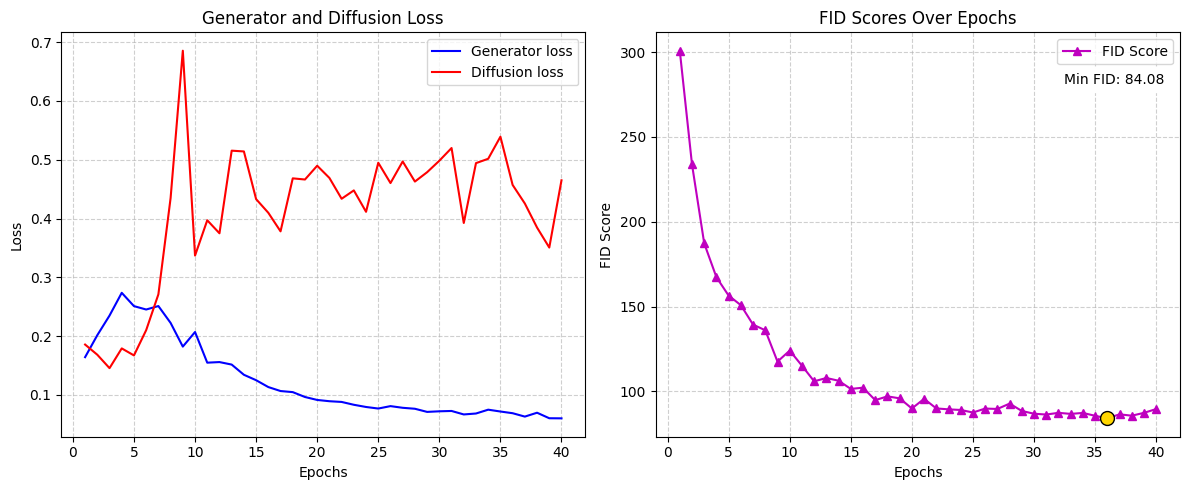

In [54]:
import json
import matplotlib.pyplot as plt

def plot_combined(loss_g, loss_d, fid_scores):
    """Fancy plot from ChatGPT."""
    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # figsize to ensure plots are not too cramped

    # Plotting training and validation losses on the first subplot
    epochs = range(1, len(loss_g) + 1)
    ax1.plot(epochs, loss_g, 'b', label='Generator loss')
    ax1.plot(epochs, loss_d, 'r', label='Diffusion loss')
    ax1.set_title('Generator and Diffusion Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    # Adding a fancy grid
    ax1.grid(True, linestyle='--', alpha=0.6)

    # Plotting FID scores on the second subplot
    ax2.plot(epochs, fid_scores, 'm^-', label='FID Score')  # 'm^-' uses magenta triangles
    ax2.set_title('FID Scores Over Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('FID Score')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.6)
    min_fid_score = min(fid_scores)
    min_fid_epoch = fid_scores.index(min_fid_score) + 1
    ax2.scatter(min_fid_epoch, min_fid_score, color='gold', s=100, edgecolor='black', zorder=5)
    ax2.text(0.97, 0.9, f'Min FID: {min_fid_score:.2f}', transform=ax2.transAxes, fontsize=10, ha='right', va='top', backgroundcolor='white')

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()

def read_training_logs():
    file_path = OUTPUT_DIR / "log.txt"
    loss_g, loss_d, fid = [], [], []
    with open(file_path, 'r') as file:
        for line in file:
            data = json.loads(line)
            loss_g.append(data["train_loss_g"])
            loss_d.append(data["train_loss_d"])
            fid.append(data["test_fid"])
    return loss_g, loss_d, fid

# Example usage:

loss_g, loss_d, test_fid = read_training_logs()
plot_combined(loss_g, loss_d, test_fid)

In [66]:
# At this point we can free memory for mu_fake and mu_real
import gc

del mu_fake
del mu_real
torch.cuda.empty_cache()
gc.collect()

22863

## **Generate Samples**

As we have a one-step generator model, we can generate samples for qualitative inspection.

In [9]:
import math

from dmd.utils.array import torch_to_pillow
from dmd.modeling_utils import load_dmd_model, load_edm, encode_labels
from dmd.utils.common import seed_everything

SIZE = 50
SEED = 42  # Create the same samples to compare the last and the best
SAMPLING_DEVICE = DEVICE  # You can change this to "cpu" or "cuda" accordingly


def closest_divisors(n: int):
    """
    Helper function for finding closest integer divisors.
    Taken from https://stackoverflow.com/a/40700741
    """
    a = round(math.sqrt(n))
    while n%a > 0: a -= 1
    return a,n//a


def generate_samples(model, class_id: int, size: int = 25, seed: int = 42):
    model.eval().to(SAMPLING_DEVICE)
    seed_everything(seed)
    class_ids = torch.zeros(size, dtype=torch.int64, device=SAMPLING_DEVICE)
    class_ids += class_id
    class_labels = encode_labels(class_ids, model.label_dim)
    z = torch.randn((size, 3, 32, 32), device=SAMPLING_DEVICE)
    g_sigma = get_fixed_generator_sigma(size, device=SAMPLING_DEVICE)
    z = z * g_sigma[0, 0]
    with torch.no_grad():
        out = model(z, g_sigma, class_labels=class_labels)
    return out


def display_samples(samples: torch.Tensor):
    pims = torch_to_pillow(samples)
    n_row, n_col = closest_divisors(len(samples))
    return image_grid(pims, n_row, n_col)

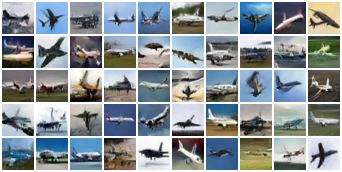

In [50]:
samples = generate_samples(generator, class_id=0, size=SIZE, seed=SEED)
display_samples(samples)

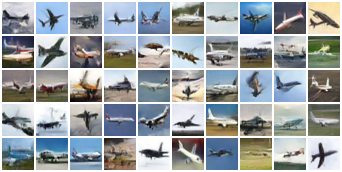

In [10]:
# load best model
best_model = load_dmd_model(OUTPUT_DIR / "best_checkpoint.pt")
samples = generate_samples(best_model, class_id=0, size=SIZE, seed=SEED)
display_samples(samples)

## Pretrained model

A pretrained DMD model on CIFAR-10 for conditional generation is available at [here](https://huggingface.co/Devrim/dmd-cifar-10-cond). The following code block loads and generate samples from it. The training logs can be reviewed [here](https://app.neptune.ai/o/metu-ms/org/DMD/runs/details?viewId=9bec4520-3b42-4d41-898f-fe8edf6221c2&detailsTab=charts&shortId=DMD-32&type=run). As we will compute below, our FID score is not sufficiently close due to the time and hardware constraints. Nonetheless, the pretrained model when investigated qualitatively can reach a satisfactory level. We provide comparison to ground truth (CIFAR-10) images, teacher model's outputs (EDM) and the results provided in the paper (DMD). 

In [45]:
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms

from dmd import PROJECT_ROOT
from dmd.modeling_utils import load_dmd_model
from dmd.fid import FID

SEED = 100

# pretrained model is downloaded with scripts/download_data.sh
cifar10_dmd_model = load_dmd_model(PROJECT_ROOT / "models/dmd_cifar_10_cond.pt", device="cuda")

In [46]:
cifar_test = CIFAR10(
    root=(PROJECT_ROOT / "data").as_posix(), train=False, download=True, transform=transforms.ToTensor()
)
cifar_test_loader = DataLoader(cifar_test, batch_size=128, shuffle=False, num_workers=12)
fid = FID(cifar_test_loader)
fid(cifar10_dmd_model)

Files already downloaded and verified


FID - Real Data Feature Extraction: 100%|███████| 79/79 [00:06<00:00, 13.04it/s]


4.519107717858283

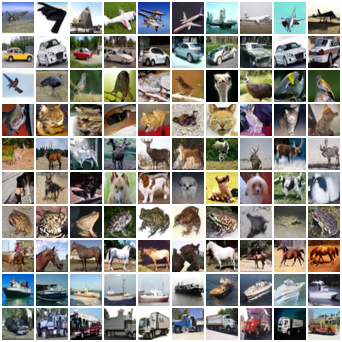

In [36]:
all_samples = []
for class_id in range(10):
    samples = generate_samples(cifar10_dmd_model, class_id=class_id, size=10, seed=(class_id + 1) * SEED)
    all_samples.append(samples)
all_samples = torch.vstack(all_samples)
display_samples(all_samples)

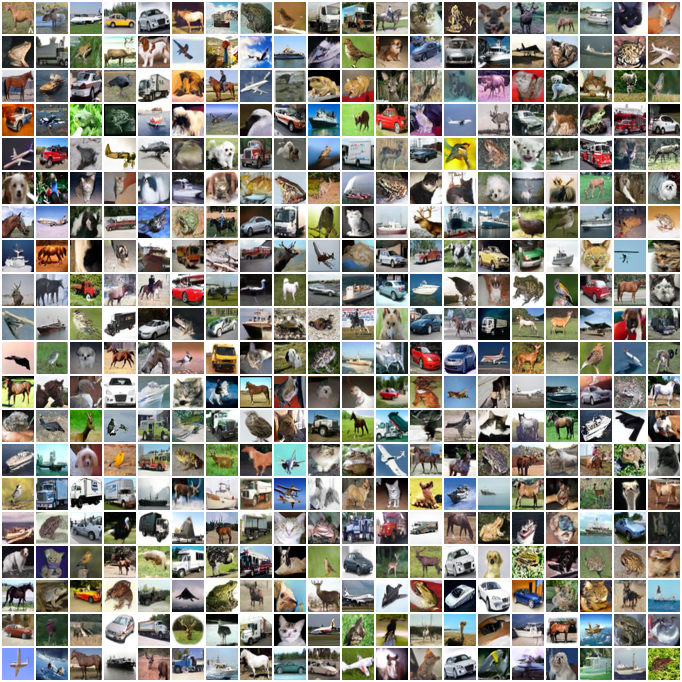

In [35]:
SEED = 100

cifar10_dmd_model = load_dmd_model(PROJECT_ROOT / "models/dmd_cifar_10_cond.pt", device="cpu")
all_samples = []
for class_id in range(10):
    samples = generate_samples(cifar10_dmd_model, class_id=class_id, size=40, seed=(class_id + 1) * SEED)
    all_samples.append(samples)
all_samples = torch.vstack(all_samples)

idx = torch.randperm(all_samples.shape[0])

all_samples = all_samples[idx]

display_samples(all_samples)

## DMD Quantitative Results

The following results is the results provided in the paper for CIFAR-10 dataset.

<center><img width="520" src="assets/cifar10_results.png"></center>

**NOTE:** We also want to remark that [the base model (EDM)](https://arxiv.org/pdf/2206.00364) reaches **1.79** FID score on CIFAR-10 in a class-conditional setting.

## DMD Qualitative comparison

Below you can see CIFAR-10 images vs. DMD Model outputs (each row represents a class).

<center><img src="assets/cifar_vs_dmd.png"></center>

, and we also provide EDM (base pretrained model/teacher model) vs. DMD Model Outputs below.

<center><img src="assets/edm_vs_dmd.png"></center>

The following image compares (left) the model outputs provided in the paper, and  (right) results with our trained model. Since there was no specific pattern in Fig 12. in the paper, we shuffled our images as well, to have a consistent revision. 

<center><img src="assets/paper_vs_dmd.png"></center>

## **References**

Karras, T., Aittala, M., Aila, T., & Laine, S. (2022). Elucidating the design space of diffusion-based generative models. Advances in Neural Information Processing Systems, 35, 26565-26577.

## Response to the Peer-Review

We'd like to thank the peer-reviewer's comments, see the [Peer-Review of Group 03](https://github.com/gcinbis/DeepGenerativeModels-2024-Spring-Projects-Version1/blob/main/Peer%20reviews/ReviewedGroup03_ByGroup4.pdf).

- **Re: [Pretrained model]** This was implicitly laid out as the reviewer's comment suggested. We included a section for loading the pretrained model (the model download is done by the `scripts/download_data.sh`).
- **Re: [Achieving the goals]** In a quantitative perspective our goal (the paper result) was to reach **2.66** FID score, however due to the time and compute resources constraints it is not realistic for us to achieve that result. Nonetheless, we continued training for 74.5 hours and got the FID score of 4.43 as [the best result](https://app.neptune.ai/o/metu-ms/org/DMD/runs/table?viewId=9bec4520-3b42-4d41-898f-fe8edf6221c2&detailsTab=charts&shortId=DMD-32&type=run), and as reviewer's mentioned the results qualitatively satisfactory.
- **Re: [Figures & Tables]** We have updated the notebook and added the results sections (quantitative and qualitative) providing the tables and figures along with our results for comparison. 
- **Re: [Reporting the paper results]** As we mentioned in **Re: [Figures & Tables]**, we have added this section also by including the paper and our results for convenient comparison.